In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### На основе двух датасетов определить, какие фильмы чаще всего получают высокий рейтинг и какие фильмы являются наиболее обсуждаемыми на платформе
Описание полей датасета: **titles**
```
    - id: The title ID on JustWatch.
    - title: The name of the title.
    - show_type: TV show or movie.
    - description: A brief description.
    - release_year: The release year.
    - age_certification: The age certification.
    - runtime: The length of the episode (SHOW) or movie.
    - genres: A list of genres.
    - production_countries: A list of countries that produced the title.
    - seasons: Number of seasons if it's a SHOW.
    - imdb_id: The title ID on IMDB.
    - imdb_score: Score on IMDB.
    - imdb_votes: Votes on IMDB.
    - tmdb_popularity: Popularity on TMDB.
    - tmdb_score: Score on TMDB.
```    
Описание полей датасета **credits**. Данные сет содержит информацию об актерах
и режиссерах
```
    - person_ID: The person ID on JustWatch.
    - id: The title ID on JustWatch.
    - name: The actor or director's name.
    - character_name: The character name.
    - role: ACTOR or DIRECTOR.
```

In [2]:
tit = pd.read_excel('Titles.xlsx')
tit.sample(3)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
571,tm29028,Salt of This Sea,MOVIE,Born in Brooklyn to Palestinian refugee parent...,2008,NaN,109,"['drama', 'romance', 'european']","['BE', 'FR', 'ES', 'CH', 'PS']",NaN,tt1090680,6.8,1235.0,1.738,6.3
4417,tm435836,Mere Pyare Prime Minister,MOVIE,A story about four children living in a Mumbai...,2019,NaN,104,['drama'],['IN'],NaN,tt8207768,6.8,646.0,1.988,7.2
5362,tm1191860,Oprah + Viola: A Netflix Special Event,MOVIE,"In this special event, Oprah Winfrey sits down...",2022,NaN,48,['documentation'],['US'],NaN,tt19404044,7.2,319.0,3.035,7.7


In [3]:
# только фильмы
mov = tit[tit.type=="MOVIE"]

In [4]:
mov.shape

(3744, 15)

In [5]:
mov.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,3744.000000,3744.000000,0.0,3429.000000,3.413000e+03,3682.000000,3549.000000
mean,2015.870994,98.213675,NaN,6.246748,2.690938e+04,20.314546,6.464012
std,7.622202,30.640640,NaN,1.127486,1.068378e+05,78.066405,1.043817
min,1954.000000,2.000000,NaN,1.500000,5.000000e+00,0.009442,1.000000
25%,2015.000000,85.000000,NaN,5.600000,5.600000e+02,2.509250,5.900000
50%,2018.000000,98.000000,NaN,6.400000,2.591000e+03,5.862000,6.500000
75%,2020.000000,115.000000,NaN,7.100000,1.154500e+04,14.657250,7.100000
max,2022.000000,240.000000,NaN,9.100000,2.294231e+06,2274.044000,10.000000


In [6]:
# колонка сезоны нужна для шоу, удаляем
mov = mov.drop('seasons', axis=1)

In [7]:
mov = mov.dropna(subset=['imdb_id','imdb_score','imdb_votes','tmdb_popularity','tmdb_score']).copy()
mov.isnull().sum()

id                         0
title                      0
type                       0
description                1
release_year               0
age_certification       1997
runtime                    0
genres                     0
production_countries       0
imdb_id                    0
imdb_score                 0
imdb_votes                 0
tmdb_popularity            0
tmdb_score                 0
dtype: int64

<AxesSubplot:>

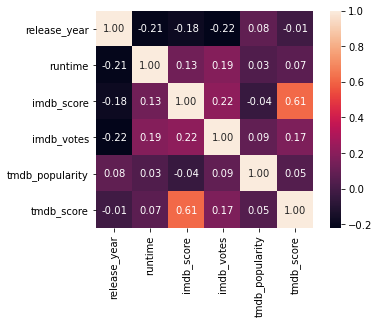

In [8]:
sns.heatmap(data=mov.corr(),cbar=True, annot=True, square=True, fmt= ".2f", annot_kws={"size":10,})

Есть незначительная отрицательная корреляция *runtime* - *release year*. 

Новые фильмы становятся длиннее.


В рейтинге TMDB популярность фильма не коррелирует с его рейтингом.


Рейтинги TMDB и IMDB имеют среднюю корреляцию.

### Наиболее часто встречающиеся слова в названиях и описаниях фильмов

In [9]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]') 
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
from nltk.corpus import stopwords
stop = stopwords.words('english')

def text_prepare(row):
    row = str(row).lower()
    row = re.sub(REPLACE_BY_SPACE_RE, ' ', row)
    row = re.sub(BAD_SYMBOLS_RE, '', row)
    return row

In [10]:
mov['descr_words'] = mov['description'].apply(text_prepare).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [11]:
mov['descr_words'].sample(2)

3283    nba lockout sports agent ray burke presents ro...
3959    medieval english knight magically transported ...
Name: descr_words, dtype: object

In [12]:
pd.Series(' '.join(mov['descr_words']).lower().split()).value_counts().head(5)

life      525
love      368
one       353
family    348
young     337
dtype: int64

In [13]:
mov['words_title'] = mov['title'].apply(text_prepare).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [14]:
pd.Series(' '.join(mov['words_title']).lower().split()).value_counts().head(5)

love         68
2            61
christmas    55
movie        45
man          33
dtype: int64

### Количество фильмов по годам выпуска

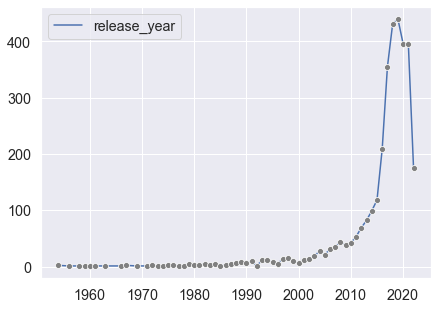

In [15]:
mov_yearly = pd.DataFrame(mov.release_year.value_counts())
plt.figure(figsize=(7, 5))
sns.set(context='notebook',style='darkgrid',palette='deep', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
sns.lineplot(data=mov_yearly, marker='o', markerfacecolor='grey')
plt.show()

In [16]:
# Наибольшее количество фильмов в датасете выпущены в 2019 году
mov.release_year.value_counts().sort_values(ascending=False).head(4)

2019    440
2018    431
2021    396
2020    396
Name: release_year, dtype: int64

#### Процент самых популярных и обсуждаемых фильмов в IMDB и в TMDB среди всех выпущенных в этом году

In [17]:
IMDB75 = mov.imdb_votes.quantile(0.75)
TMDB75 = mov.tmdb_popularity.quantile(0.75)

IMDB75S = mov.imdb_score.quantile(0.75)
TMDB75S = mov.tmdb_score.quantile(0.75)

IMDB50 = mov.imdb_votes.quantile(0.50)
TMDB50 = mov.tmdb_popularity.quantile(0.50)

IMDB50S = mov.imdb_score.quantile(0.50)
TMDB50S = mov.tmdb_score.quantile(0.50)

print(f'TMDB50S = {TMDB50S}',
      f'TMDB75S = {TMDB75S}',
      f'IMDB50S = {IMDB50S}',
      f'IMDB75S = {IMDB75S}', 
      f'TMDB50 = {TMDB50}', 
      f'TMDB75 = {TMDB75}',
      f'IMDB50 = {IMDB50}',
      f'IMDB75 = {IMDB75}',sep='\n')

TMDB50S = 6.5
TMDB75S = 7.1
IMDB50S = 6.4
IMDB75S = 7.1
TMDB50 = 6.607
TMDB75 = 15.604
IMDB50 = 2854.0
IMDB75 = 12446.5


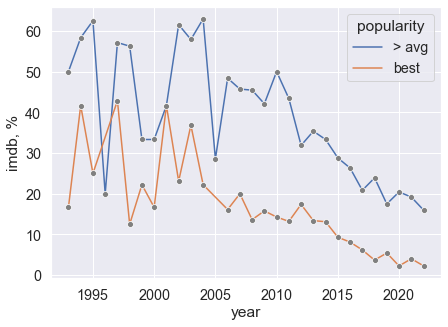

In [18]:
df75 = pd.DataFrame(mov.query('(imdb_votes > @IMDB75) & (imdb_score > @IMDB75S)').release_year.value_counts())
df75 = df75.join(mov_yearly, how='left', lsuffix='_50', rsuffix='').copy()
df75['popularity'] = 'best'

df50 = pd.DataFrame(mov.query('(imdb_votes > @IMDB50) & (imdb_score > @IMDB50S)').release_year.value_counts())
df50 = df50.join(mov_yearly, how='left', lsuffix='_50', rsuffix='').copy()
df50['popularity'] = '> avg'

df = pd.concat([df50, df75]).reset_index()
df.rename(columns={'index':'year','release_year':'movies'}, inplace=True)
df['imdb, %'] = (df['release_year_50']/ df['movies']*100).round(2)
sns.set(context='notebook',style='darkgrid',palette='deep', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
plt.figure(figsize=(7, 5))
sns.lineplot(data = df.loc[df.year > 1992 ], x = 'year', y='imdb, %', hue = 'popularity', marker='o', markerfacecolor='grey')
plt.show()

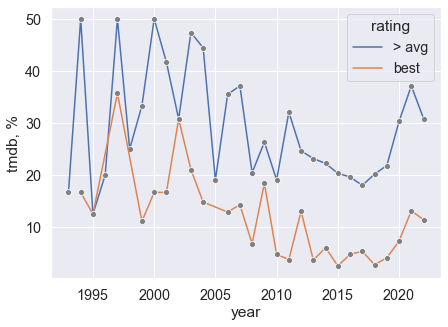

In [19]:
df75 = pd.DataFrame(mov.query('(tmdb_popularity > @TMDB75) & (tmdb_score > @TMDB75S)').release_year.value_counts())
df75 = df75.join(mov_yearly, how='left', lsuffix='_50', rsuffix='').copy()
df75['rating'] = 'best'


df50 = pd.DataFrame(mov.query('(tmdb_popularity > @TMDB50) & (tmdb_score > @TMDB50S)').release_year.value_counts())
df50 = df50.join(mov_yearly, how='left', lsuffix='_50', rsuffix='').copy()
df50['rating'] = '> avg'

df = pd.concat([df50, df75]).reset_index()
df.rename(columns={'index':'year','release_year':'movies'}, inplace=True)
df['tmdb, %'] = (df['release_year_50']/ df['movies']*100).round(2)
sns.set(context='notebook',style='darkgrid',palette='deep', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
plt.figure(figsize=(7, 5))
sns.lineplot(data = df.loc[df.year > 1992 ], x = 'year', y='tmdb, %', hue = 'rating', marker='o', markerfacecolor='grey')
plt.show()

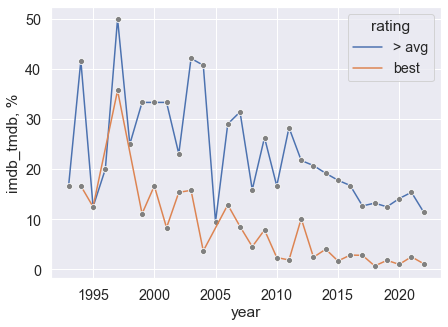

In [20]:
df75 = pd.DataFrame(mov.query('(tmdb_popularity > @TMDB75) & (tmdb_score > @TMDB75S)&(imdb_votes > @IMDB75) & (imdb_score > @IMDB75S)').release_year.value_counts())
df75 = df75.join(mov_yearly, how='left', lsuffix='_50', rsuffix='').copy()
df75['rating'] = 'best'


df50 = pd.DataFrame(mov.query('(tmdb_popularity > @TMDB50) & (tmdb_score > @TMDB50S)&(imdb_votes > @IMDB50) & (imdb_score > @IMDB50S)').release_year.value_counts())
df50 = df50.join(mov_yearly, how='left', lsuffix='_50', rsuffix='').copy()
df50['rating'] = '> avg'

df = pd.concat([df50, df75]).reset_index()
df.rename(columns={'index':'year','release_year':'movies'}, inplace=True)
df['imdb_tmdb, %'] = (df['release_year_50']/ df['movies']*100).round(2)
sns.set(context='notebook',style='darkgrid',palette='deep', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
plt.figure(figsize=(7, 5))
sns.lineplot(data = df.loc[df.year > 1992 ], x = 'year', y='imdb_tmdb, %', hue = 'rating', marker='o', markerfacecolor='grey')
plt.show()

### Сертификация по возрасту

In [21]:
mov.age_certification.value_counts()

R        526
PG-13    425
PG       220
G         88
NC-17     15
Name: age_certification, dtype: int64

In [22]:
df75 = mov.query('(imdb_votes > @IMDB75) & (tmdb_popularity > @TMDB75)')
df50 = mov.query('(imdb_votes > @IMDB50) & (tmdb_popularity > @TMDB50)')

In [23]:
print(df75.shape, df50.shape)

(461, 16) (1258, 16)


In [24]:
pd.DataFrame(df75.age_certification.value_counts())\
.join(pd.DataFrame(df50.age_certification.value_counts()),how='left', lsuffix='_75', rsuffix='_50')\
.join(mov.age_certification.value_counts(), how='left')

,age_certification_75,age_certification_50,age_certification
R,207,408,526
PG-13,126,265,425
PG,53,114,220
NC-17,4,11,15
G,3,16,88


Сертификация по возрасту не влияет на популярность фильма

In [25]:
df75s = mov.query('(imdb_score > @IMDB75S) & (tmdb_score > @TMDB75S)')
df50s = mov.query('(imdb_score > @IMDB50S) & (tmdb_score > @TMDB50S)')

In [26]:
pd.DataFrame(df75s.age_certification.value_counts())\
.join(pd.DataFrame(df50s.age_certification.value_counts()),how='left', lsuffix='_75', rsuffix='_50')\
.join(mov.age_certification.value_counts(), how='left')

,age_certification_75,age_certification_50,age_certification
R,95,212,526
PG-13,76,198,425
PG,34,87,220
G,14,29,88
NC-17,3,6,15


Сертификация по возрасту не влияет на рейтинг фильма

### Продолжительность фильма

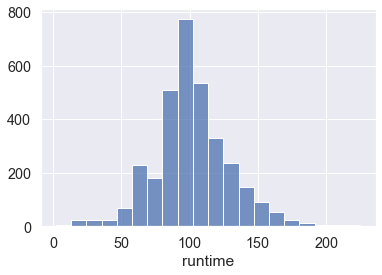

In [27]:
ax = sns.histplot(data=mov, x="runtime", bins=20)
ax.set(xlabel='runtime', ylabel='')
plt.show()

In [28]:
mov['t75'] = (mov.tmdb_score > TMDB75S) & (mov.tmdb_popularity > TMDB75)

In [29]:
mov['t50'] = (mov.tmdb_score > TMDB50S) & (mov.tmdb_popularity > TMDB50)

In [30]:
mov['i75'] = (mov.imdb_score > IMDB75S) & (mov.imdb_votes > IMDB75)

In [31]:
mov['i50'] = (mov.imdb_score > IMDB50S) & (mov.imdb_votes > IMDB50)

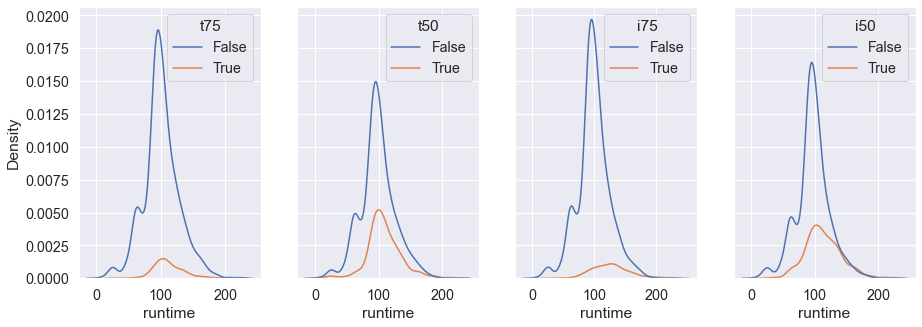

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

sns.kdeplot(ax=axes[0], data=mov, hue = 't75', x="runtime")
sns.kdeplot(ax=axes[1], data=mov, hue = 't50', x="runtime")
sns.kdeplot(ax=axes[2], data=mov, hue = 'i75', x="runtime")
sns.kdeplot(ax=axes[3], data=mov, hue = 'i50', x="runtime")
plt.show()

<AxesSubplot:xlabel='runtime', ylabel='Density'>

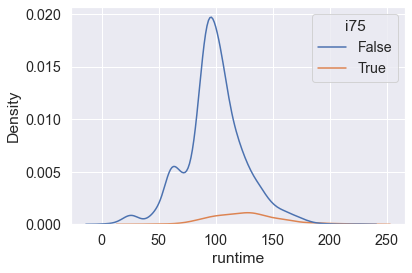

In [33]:
sns.kdeplot(data=mov, hue = 'i75', x="runtime")

<AxesSubplot:xlabel='tmdb_popularity', ylabel='tmdb_score'>

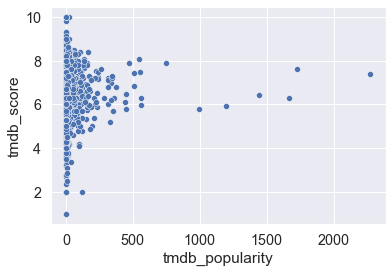

In [34]:
sns.scatterplot(data = mov, x = "tmdb_popularity", y = "tmdb_score")

<AxesSubplot:xlabel='imdb_votes', ylabel='imdb_score'>

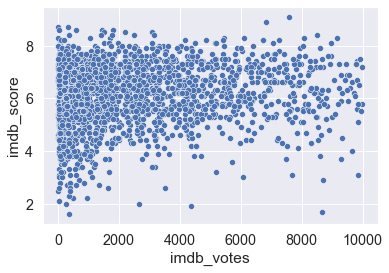

In [35]:
sns.scatterplot(data = mov[mov.imdb_votes<1e4], x = "imdb_votes", y = "imdb_score")

### Какие жанры пользуются наибольшей популярностью

In [36]:
def transform_to_list(row):    
    return row[1:-1].replace("'","").replace(" ","").split(",")

In [37]:
mov['genres'] = mov['genres'].apply(lambda x: x[1:-1].replace("'","").replace(" ","").split(","))

In [38]:
dg = mov.explode('genres')
dg.sample(3)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,descr_words,words_title,t75,t50,i75,i50
2061,tm352774,Voyeur,MOVIE,Journalism icon Gay Talese reports on Gerald F...,2017,R,95,documentation,['US'],tt3465276,6.1,6097.0,9.593,6.0,journalism icon gay talese reports gerald foos...,voyeur,False,False,False,False
2297,tm299764,The Motive,MOVIE,"ГЃlvaro, a man obsessed with the idea of writi...",2017,NaN,104,drama,"['ES', 'MX']",tt5451244,6.5,5713.0,6.409,6.2,lvaro man obsessed idea writing brands high li...,motive,False,False,False,True
5079,tm1161601,Ben & Jody,MOVIE,Two best friends band together with a group of...,2022,NaN,114,action,['ID'],tt13393058,5.4,222.0,5.486,5.7,two best friends band together group villages ...,ben jody,False,False,False,False


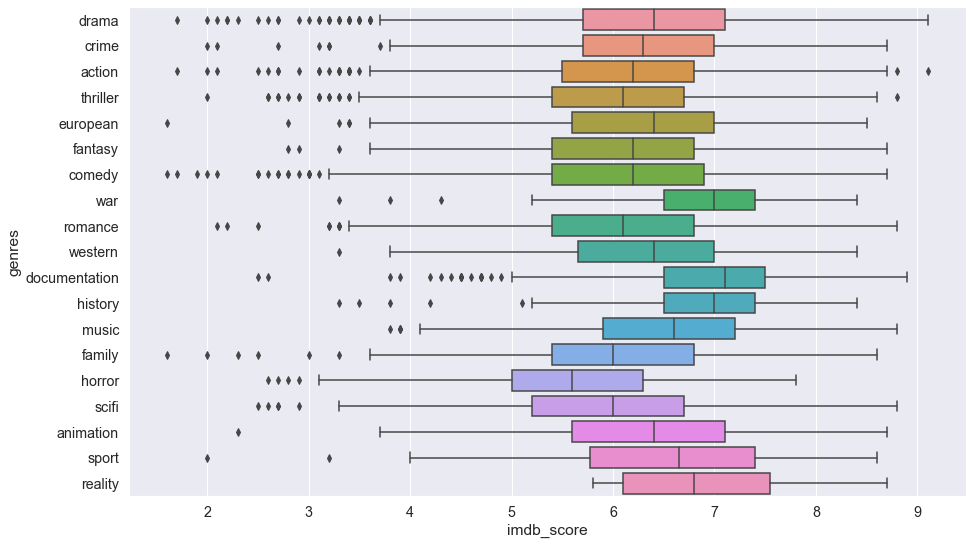

In [39]:
plt.figure(figsize=(15, 9))
sns.boxplot(data=dg, x="imdb_score", y="genres")
plt.show()

In [40]:
# Весь датасет
pd.DataFrame(dg.genres.value_counts()).head(10)

,genres
drama,1727
comedy,1447
thriller,773
action,670
romance,661
crime,522
documentation,514
european,328
family,323
fantasy,299


In [41]:
# Популярность и рейтинг больше среднего в IMDB
a1 = pd.DataFrame(dg[(dg.imdb_score>IMDB50S)&(dg.imdb_votes>IMDB50)].genres.value_counts()).join(pd.DataFrame(dg.genres.value_counts()),how='left',lsuffix='50')
a1['pr']=(a1.genres50/a1.genres*100).round(2)
a1.sort_values(by='pr', ascending=False).head(10)

,genres50,genres,pr
history,80,142,56.34
war,54,96,56.25
western,12,28,42.86
reality,3,8,37.50
crime,177,522,33.91
european,111,328,33.84
drama,562,1727,32.54
fantasy,91,299,30.43
sport,34,112,30.36
action,198,670,29.55


In [42]:
# Популярность и рейтинг больше среднего в TMDB
a2 = pd.DataFrame(dg[(dg.tmdb_score>TMDB50S)&(dg.tmdb_popularity>TMDB50)].genres.value_counts()).join(pd.DataFrame(dg.genres.value_counts()),how='left',lsuffix='50')
a2['pr']=(a2.genres50/a2.genres*100).round(2)
a2.sort_values(by='pr', ascending=False).head(10)

,genres50,genres,pr
animation,117,211,55.45
history,75,142,52.82
war,47,96,48.96
fantasy,145,299,48.49
family,128,323,39.63
western,11,28,39.29
scifi,69,193,35.75
sport,40,112,35.71
european,112,328,34.15
action,221,670,32.99


In [43]:
# Популярность и рейтинг больше среднего в IMDB и в TMDB
a3 = pd.DataFrame(dg[(dg.tmdb_score>TMDB50S)&(dg.tmdb_popularity>TMDB50)&(dg.imdb_score>IMDB50S)&(dg.imdb_votes>IMDB50)].genres.value_counts()).join(pd.DataFrame(dg.genres.value_counts()),how='left',lsuffix='50')
a3['pr']=(a3.genres50/a3.genres*100).round(2)
a3.sort_values(by='pr', ascending=False).head(10)

,genres50,genres,pr
war,43,96,44.79
history,62,142,43.66
western,10,28,35.71
fantasy,84,299,28.09
european,87,328,26.52
animation,54,211,25.59
reality,2,8,25.00
scifi,47,193,24.35
drama,380,1727,22.00
action,139,670,20.75


### В каких странах больше всего выпущено фильмов

In [44]:
mov['production_countries'] = mov['production_countries'].apply(lambda x: x[1:-1].replace("'","").replace(" ","").split(","))

In [45]:
dc = mov.explode('production_countries')
dc.sample(3)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,descr_words,words_title,t75,t50,i75,i50
2184,tm313293,Whose Streets?,MOVIE,A nonfiction account of the Ferguson uprising ...,2017,R,90,[documentation],US,tt6176928,5.5,1337.0,2.526,5.8,nonfiction account ferguson uprising told peop...,whose streets,False,False,False,False
2669,tm411313,Forgive Us Our Debts,MOVIE,"Threatened by creditors, a newly unemployed ma...",2018,NaN,104,"[drama, european]",CH,tt6679412,6.2,1604.0,5.855,6.1,threatened creditors newly unemployed man agre...,forgive us debts,False,False,False,False
2115,tm347530,Gaga: Five Foot Two,MOVIE,Go behind the scenes with pop provocateur Lady...,2017,NaN,100,"[music, documentation]",US,tt7291268,7.0,12937.0,8.707,7.5,go behind scenes pop provocateur lady gaga rel...,gaga five foot two,False,True,False,True


In [46]:
pd.DataFrame(dc.production_countries.value_counts()).sort_values(by = 'production_countries', ascending=False).head(10).style.bar(color='yellow')

,production_countries
US,1354
IN,532
GB,235
FR,170
CA,135
ES,127
JP,99
DE,99
PH,77
,75


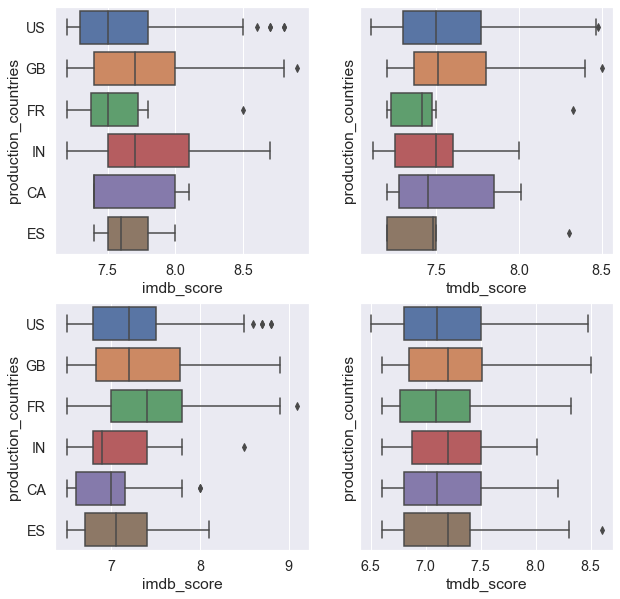

In [47]:
countries_to_keep = ['US','IN','GB','FR','CA','ES']
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

sns.boxplot(ax=axes[0, 0], data=dc[dc.production_countries.isin(countries_to_keep) & (dc.i75==True)], x="imdb_score", y="production_countries")
sns.boxplot(ax=axes[0, 1], data=dc[dc.production_countries.isin(countries_to_keep) & (dc.t75==True)], x="tmdb_score", y="production_countries")
sns.boxplot(ax=axes[1, 0], data=dc[dc.production_countries.isin(countries_to_keep) & (dc.i50==True)], x="imdb_score", y="production_countries")
sns.boxplot(ax=axes[1, 1], data=dc[dc.production_countries.isin(countries_to_keep) & (dc.t50==True)], x="tmdb_score", y="production_countries")
plt.show()

В рейтинге TMDB средние значения незначительно смещены друг относительно друга. Распределения оценок для фильмов с рейтингом и популярностью выше среднего также отличаются незначительно.

В рейтинге IMDB, напротив, можно выделить Канаду, где средний рейтинг фильма и распределение оценок в целом смещёно влево относительно других стран.

### Какие режиссёры сняли больше всего фильмов

In [48]:
cr = pd.read_excel('Credits.xlsx')
cr.sample(3)

,person_id,id,name,character,role
13786,524,ts27468,Jeff Bennett,Huxley Prescott (voice),ACTOR
28731,45280,tm244364,Nathaniel Dean,Stoakes,ACTOR
66804,1052898,tm1064228,Raynnie Platz,Private school student,ACTOR


In [49]:
dr = cr.loc[cr.role == 'DIRECTOR'][['id','name']].set_index('id')
dr.sample(3)

,name
id,
tm470836,Simon Lupton
tm1033635,Tone GrГёttjord-Glenne
tm183805,Raj Kumar Gupta


In [50]:
name = mov.merge(dr, how='left', on ='id')
name.sample(3)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,imdb_id,...,imdb_votes,tmdb_popularity,tmdb_score,descr_words,words_title,t75,t50,i75,i50,name
1963,tm307383,Ghost Hunting,MOVIE,"A set-up for an experiment in an empty room, F...",2017,NaN,94,"[documentation, european]","[FR, PS, CH, QA]",tt6568868,...,222.0,1.897,6.3,setup experiment empty room former inmates rec...,ghost hunting,False,False,False,False,NaN
1776,tm443034,Your Son,MOVIE,"Jaime, a doctor who lives in Seville, finds hi...",2018,NaN,103,"[drama, crime, thriller, action, european]",[ES],tt7807026,...,4796.0,10.487,5.7,jaime doctor lives seville finds life radicall...,son,False,False,False,False,Miguel ГЃngel Vivas
3543,tm1122095,A Naija Christmas,MOVIE,A mother's Christmas wish - and the grand priz...,2021,NaN,121,"[comedy, drama, romance]",[NG],tt15565704,...,342.0,18.261,7.0,mothers christmas wish grand prize comes sets ...,naija christmas,False,True,False,False,Kunle Afolayan


In [51]:
# Число обсуждаемых больше среднего в IMDB и общее число работ
pd.DataFrame(name[name.imdb_votes>IMDB50].groupby('name').title.nunique().sort_values(ascending=False))\
.merge(pd.DataFrame(name.groupby('name').title.nunique().sort_values(ascending=False)), how='inner', on='name', suffixes=('_i50', '')).head(5)

,title_i50,title
name,,
Jay Karas,7,14
Anurag Kashyap,6,6
Mani Ratnam,6,6
Imtiaz Ali,5,5
Ashutosh Gowariker,5,6


In [52]:
# Число обсуждаемых больше среднего  в TMDB и общее число работ
pd.DataFrame(name[name.tmdb_popularity>TMDB50].groupby('name').title.nunique().sort_values(ascending=False))\
.merge(pd.DataFrame(name.groupby('name').title.nunique().sort_values(ascending=False)), how='inner', on='name', suffixes=('_t50', '')).head(5)

,title_t50,title
name,,
Martin Scorsese,5,5
Steven Brill,5,5
Ernie Barbarash,4,4
Ashutosh Gowariker,4,6
Savage Steve Holland,4,4


In [53]:
# По рейтигу в IMDB и TMDB
pd.DataFrame(name[(name.imdb_votes>IMDB50) & (name.tmdb_popularity>TMDB50)].groupby('name').title.nunique().sort_values(ascending=False))\
.merge(pd.DataFrame(name.groupby('name').title.nunique().sort_values(ascending=False)), how='inner', on='name', suffixes=('_50', '')).head(5)

,title_50,title
name,,
Martin Scorsese,5,5
Steven Brill,5,5
James Wan,4,4
Ashutosh Gowariker,4,6
Karan Johar,4,5


In [54]:
# Число работ с рейтингом больше среднего TMDB
pd.DataFrame(name[name.tmdb_score>TMDB50S].groupby('name').title.nunique().sort_values(ascending=False))\
.merge(pd.DataFrame(name.groupby('name').title.nunique().sort_values(ascending=False)), how='inner', on='name', suffixes=('_t50', '')).head(5)

,title_t50,title
name,,
Jay Karas,10,14
Cathy Garcia-Molina,9,12
Marcus Raboy,7,14
Ryan Polito,7,15
Shannon Hartman,6,7


In [55]:
# Число работ с рейтингом больше среднего IMDB
pd.DataFrame(name[name.imdb_score>IMDB50S].groupby('name').title.nunique().sort_values(ascending=False))\
.merge(pd.DataFrame(name.groupby('name').title.nunique().sort_values(ascending=False)), how='inner', on='name', suffixes=('_i50', '')).head(5)

,title_i50,title
name,,
Cathy Garcia-Molina,11,12
Youssef Chahine,10,11
Marcus Raboy,9,14
Jay Chapman,9,11
Jay Karas,9,14


In [56]:
# По скору в IMDB и TMDB
pd.DataFrame(name[(name.imdb_score>IMDB50S) & (name.tmdb_score>TMDB50S)].groupby('name').title.nunique().sort_values(ascending=False))\
.merge(pd.DataFrame(name.groupby('name').title.nunique().sort_values(ascending=False)), how='inner', on='name', suffixes=('_50', '')).head(5)

,title_50,title
name,,
Cathy Garcia-Molina,9,12
Jay Karas,9,14
Marcus Raboy,7,14
Shannon Hartman,6,7
Jay Chapman,6,11


In [57]:
# Рейтинг и популярность IMDB и TMDB
pd.DataFrame(name[(name.imdb_score>IMDB50S) & (name.tmdb_score>TMDB50S)&(name.imdb_votes>IMDB50) & (name.tmdb_popularity>TMDB50)].groupby('name').title.nunique().sort_values(ascending=False))\
.merge(pd.DataFrame(name.groupby('name').title.nunique().sort_values(ascending=False)), how='inner', on='name', suffixes=('_50', '')).head(5)

,title_50,title
name,,
Martin Scorsese,5,5
James Wan,4,4
Guy Ritchie,4,4
Ryoo Seung-wan,4,5
Farhan Akhtar,3,4


### Самые обсуждаемые фильмы

In [58]:
a1 = name[['title','imdb_votes']].sort_values(by='imdb_votes', ascending=False).drop_duplicates().reset_index(drop=True).head(100)
a2 = name[['title','tmdb_popularity']].sort_values(by='tmdb_popularity', ascending=False).drop_duplicates().reset_index(drop=True).head(100)
a1.merge(a2, how = 'inner', on = 'title')

,title,imdb_votes,tmdb_popularity
0,Inception,2294231.0,108.284
1,Titanic,1146825.0,155.683
2,The Amazing Spider-Man,646119.0,159.056
3,Don't Look Up,515337.0,120.874
4,The Conjuring,496484.0,221.925
5,Hancock,476593.0,121.985
6,How to Train Your Dragon 2,330975.0,134.700
7,The Conjuring 2,264195.0,171.724
8,Red Notice,264194.0,311.673
9,Chappie,249345.0,117.369


### Наиболее часто встречающиеся слова в названиях и описаниях обсуждаемых фильмов с рейтингом больше среднего в IMDB и TMDB

In [59]:
a1 = pd.Series(' '.join(mov[(mov.tmdb_score>TMDB50S)&(mov.tmdb_popularity>TMDB50)&(mov.imdb_score>IMDB50S)&(mov.imdb_votes>IMDB50)]['words_title']).lower().split()).value_counts().head(15)
a2 = pd.Series(' '.join(mov[(mov.tmdb_score>TMDB50S)&(mov.tmdb_popularity>TMDB50)&(mov.imdb_score>IMDB50S)&(mov.imdb_votes>IMDB50)]['descr_words']).lower().split()).value_counts().head(15)
set(a1.keys()).union(set((a2.keys())))

{'2',
 'call',
 'christmas',
 'family',
 'find',
 'girl',
 'home',
 'house',
 'life',
 'love',
 'man',
 'monster',
 'movie',
 'naruto',
 'new',
 'night',
 'one',
 'shippuden',
 'story',
 'true',
 'two',
 'war',
 'world',
 'years',
 'young'}